In [2]:
import numpy as np
import matplotlib.pyplot as plt
from operator import itemgetter
from itertools import groupby
from scipy.optimize import minimize

In [31]:
class Polychain:
    def __init__(self, data, xmin=-0.5, xmax=0.5, polyorder=2, chain_length=4):
        if polyorder != 2:
            raise NotImplemented('polyorder != 2 is not yet implemented.')
        if chain_length != 4:
            raise NotImplemented('chain_length != 4 is not yet implemented.')

        self.data = data
        self.xmin = xmin
        self.xmax = xmax
        self.polyorder = polyorder
        self.chain_length = chain_length
        
        self.sdata = data[data[:,0].argsort()]
        
    def _find_knots(self, min_chain_length=8, verbose=False):
        mean = self.sdata[:,1].mean()
        lt = np.where(self.sdata[:,1]<mean)[0]
        
        chains = []
        for k, g in groupby(enumerate(lt), lambda ix: ix[0]-ix[1]):
            chain = list(map(itemgetter(1), g))
            if len(chain) > min_chain_length:
                chains.append(chain)
        if verbose:
            print(f'{len(chains)} chains found.')
        if len(chains) < 2:
            self.knots = np.array((-0.4, -0.1, 0.1, 0.4))
        elif len(chains) == 2:
            self.knots = np.sort((self.sdata[chains[0][0],0], self.sdata[chains[0][-1],0], self.sdata[chains[1][0],0], self.sdata[chains[1][-1],0]))
        else:
            lengths = np.array([len(chain) in chains])
            l = np.argsort(lengths)[::-1]
            self.knots = np.sort((self.sdata[chains[l[0]][0],0], self.sdata[chains[l[0]][-1],0], self.sdata[chains[l[1]][0],0], self.sdata[chains[l[1]][-1],0]))

        return self.knots
    
    def _find_segments(self, knots):
        self.sdata = self.data.copy()
        self.sdata[:,0][self.sdata[:,0] < knots[0]] += 1
        self.sdata = self.sdata[self.sdata[:,0].argsort()]

        segs = [np.argmax(self.sdata[:,0]>knot) for knot in knots[1:]] + [len(self.sdata)]
        return segs

    def _build_A_matrix(self, knots, segs):
        self.A = np.zeros(shape=(len(self.sdata), 9))

        self.A[:segs[0],0] = self.sdata[:segs[0],0]**2
        self.A[segs[0]:,0] = knots[1]**2
        self.A[:segs[0],1] = self.sdata[:segs[0],0]
        self.A[segs[0]:,1] = knots[1]
        self.A[:,2] = 1.0

        for k in range(3):
            self.A[segs[k]:segs[k+1],3+2*k] = self.sdata[segs[k]:segs[k+1],0]**2-knots[k+1]**2
            self.A[segs[k]:segs[k+1],4+2*k] = self.sdata[segs[k]:segs[k+1],0]-knots[k+1]
            for j in range(k):
                self.A[segs[k]:segs[k+1],3+2*j] = knots[j+2]**2-knots[j+1]**2
                self.A[segs[k]:segs[k+1],4+2*j] = knots[j+2]-knots[j+1]

        return self.A
    
    def _fit_chain(self, knots, min_pts_per_segment=5, return_ck=False):
        segs = self._find_segments(knots)
        if np.ediff1d(segs).min() < min_pts_per_segment:
            return 1e10

        A = self._build_A_matrix(knots, segs)
        ck, ssr, rank, svd = np.linalg.lstsq(self.A, self.sdata[:,1], rcond=None)

        if return_ck:
            return ck, ssr
        return ssr
    
    def _chain_coeffs(self, ck, verbose=False):
        c0 = ck[2]
        c1 = (ck[0]-ck[3])*self.knots[1]**2 + (ck[1]-ck[4])*self.knots[1] + c0
        c2 = (ck[3]-ck[5])*self.knots[2]**2 + (ck[4]-ck[6])*self.knots[2] + c1
        c3 = (ck[5]-ck[7])*self.knots[3]**2 + (ck[6]-ck[8])*self.knots[3] + c2

        if verbose:
            print(f'segment 1:\n {self.knots[0]} < x <= {self.knots[1]}, a0={ck[0]} b0={ck[1]} c0={c0}')
            print(f'segment 2:\n {self.knots[1]} < x <= {self.knots[2]}, a0={ck[3]} b0={ck[4]} c0={c1}')
            print(f'segment 3:\n {self.knots[2]} < x <= {self.knots[3]}, a0={ck[5]} b0={ck[6]} c0={c2}')
            print(f'segment 4:\n {self.knots[3]} < x <= {self.knots[0]+1}, a0={ck[7]} b0={ck[8]} c0={c3}')

        self.coeffs = ((ck[0], ck[1], c0), (ck[3], ck[4], c1), (ck[5], ck[6], c2), (ck[7], ck[8], c3))
    
    def _chain_extremes(self):
        exts_x = [-c[1]/2/c[0] for c in self.coeffs]
        knots = np.concatenate((self.knots, [self.knots[0]+1]))
        exts_x = np.array(exts_x)
        exts_y = np.zeros(len(exts_x))
        for k in range(4):
            if exts_x[k] < knots[k] or exts_x[k] > knots[k+1]:
                exts_x[k] = np.nan
            c = self.coeffs[k]
            exts_y[k] = c[0]*exts_x[k]**2 + c[1]*exts_x[k] + c[2]
        self.extremes = np.array([exts_x, exts_y]).T
    
    def _remap(self, d, sort=True):
        ncols = 1 if len(d.shape) == 1 else d.shape[1]
        x = d if ncols == 1 else d[:,0]

        while len(x[x<self.xmin]) > 0:
            x[x<self.xmin] += 1
        while len(x[x>self.xmax]) > 0:
            x[x>self.xmax] -= 1

        if sort and ncols > 1:
            d = d[d[:,0].argsort()]
        else:
            d.sort()

        return d      
    
    def fit(self, min_chain_length=8, min_pts_per_segment=5, verbose=False):
        self._find_knots(min_chain_length=min_chain_length, verbose=verbose)
        solution = minimize(self._fit_chain, self.knots, args=(min_pts_per_segment,), method='Nelder-Mead')
        self.knots = solution.x
        ck, self.ssr = self._fit_chain(self.knots, min_pts_per_segment=min_pts_per_segment, return_ck=True)
        self._chain_coeffs(ck)
        self._chain_extremes()
        
        return self.knots, self.coeffs, self.extremes
    
    def fv(self, x):
        x[x<self.knots[0]] += 1
        y = np.empty_like(x)
        for k in range(len(self.knots)-1):
            s = (x>=self.knots[k]) & (x<self.knots[k+1])
            y[s] = self.coeffs[k][0]*x[s]**2 + self.coeffs[k][1]*x[s] + self.coeffs[k][2]
        s = x>=self.knots[3]
        y[s] = self.coeffs[3][0]*x[s]**2 + self.coeffs[3][1]*x[s] + self.coeffs[3][2]

        return y
    
    def plot(self, x):
        if x is None:
            x = self.sdata[:,0]
    
        y = self.fv(x)
        d = np.vstack((x, y)).T

        self._remap(self.sdata)
        d = self._remap(d)
        self._remap(self.extremes)

        plt.plot(data[:,0], data[:,1], 'b.')
        plt.plot(d[:,0], d[:,1], 'r-')

        for k in range(4):
            plt.axvline(self.extremes[:,0][k], ls='--')
        plt.show()


(452.37112824705076, 0.7237340423604629, 0.5414331746648339) -0.0007999339449059781
(-0.22483544371823347, 0.11335840785439022, 0.9877192199531045) 0.2520919432890936
(833.6786806364124, -700.3717254637277, 147.77697626370912) 0.42004895994766167
(-0.08999392568115683, 0.13263932708177256, 0.9525831419097699) 0.736934887981806


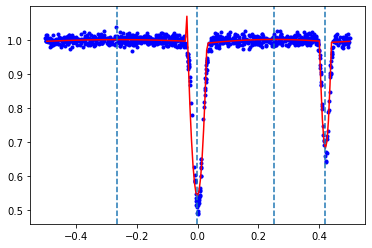

array([0.22188476])

In [85]:
data = np.loadtxt('../data/cg12.csv', delimiter=',') #np.loadtxt('lc.dat')
pc = Polychain(data)
pc.fit()
pc.plot(np.linspace(-0.5, 0.5, 201))
pc.ssr

In [86]:
pc.knots

array([-0.0360186 ,  0.0307345 ,  0.40060213,  0.43938569])

In [87]:
pc.coeffs

((452.37112824705076, 0.7237340423604629, 0.5414331746648339),
 (-0.22483544371823347, 0.11335840785439022, 0.9877192199531045),
 (833.6786806364124, -700.3717254637277, 147.77697626370912),
 (-0.08999392568115683, 0.13263932708177256, 0.9525831419097699))

In [88]:
knots_ext = np.hstack((pc.knots-0.5, pc.knots, pc.knots+0.5))

In [89]:
knots_ext

array([-0.5360186 , -0.4692655 , -0.09939787, -0.06061431, -0.0360186 ,
        0.0307345 ,  0.40060213,  0.43938569,  0.4639814 ,  0.5307345 ,
        0.90060213,  0.93938569])

In [90]:
pc.extremes

array([[-7.99933945e-04,  5.41143705e-01],
       [ 2.52091943e-01,  1.00200759e+00],
       [ 4.20048960e-01,  6.81768835e-01],
       [-2.63065112e-01,  1.00145642e+00]])

In [91]:
eclipse_args = np.argsort(pc.extremes[:,1])[:2]

In [92]:
knots1 = np.array([knots_ext[eclipse_args[0]+4], knots_ext[eclipse_args[0]+5]])
knots2 = np.array([knots_ext[eclipse_args[1]+4], knots_ext[eclipse_args[1]+5]])

In [93]:
pc.knots[eclipse_args[1]]

0.4006021295119876

In [94]:
knots_ext[eclipse_args[1]+4]

0.4006021295119876

In [95]:
np.hstack((knots1, knots2))

array([-0.0360186 ,  0.0307345 ,  0.40060213,  0.43938569])

In [96]:
pc.fv(knots2)

array([0.99704878, 0.99348876])

In [97]:
pc.fv(np.hstack((knots1, knots2))).mean()

1.0209431235084963

In [102]:
pc.coeffs[eclipse_args[0]]

(452.37112824705076, 0.7237340423604629, 0.5414331746648339)

In [99]:
knots1[knots1<pc.knots[0]]

array([], dtype=float64)

In [55]:
pc.knots[0]

-0.015073441066656527

In [59]:
np.array(knots1)[knots1 < pc.knots[0]]

array([], dtype=float64)